In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor
import cv2

import tensorflow as tf
import keras

import sys

from keras_applications.mobilenet import MobileNet, preprocess_input

from sklearn.model_selection import ShuffleSplit
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
def _get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def _get_windowing(data):
    dicom_fields = [data.WindowCenter, data.WindowWidth, data.RescaleSlope, data.RescaleIntercept]
    return [_get_first_of_dicom_field_as_int(x) for x in dicom_fields]


def _window_image(img, window_center, window_width, slope, intercept):
    img = (img * slope + intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 

def _normalize(img):
    if img.max() == img.min():
        return np.zeros(img.shape)
    #print(img.max())
    #print(img.min())
    return (img - img.min())/(img.max() - img.min())
    #return img

def _read(path, desired_size=(512, 512)):

    dcm = pydicom.dcmread(path)

    window_params = _get_windowing(dcm) # (center, width, slope, intercept)

    try:
        # dcm.pixel_array might be corrupt (one case so far)
        img = _window_image(dcm.pixel_array, *window_params)
    except:
        img = np.zeros(desired_size)

    img = _normalize(img)

    if desired_size != (512, 512):
        # resize image
        img = cv2.resize(img, desired_size, interpolation=cv2.INTER_LINEAR)

    return img[:,:,np.newaxis]

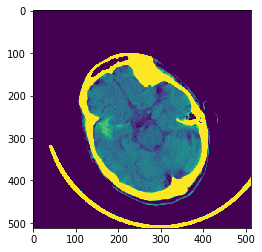

In [3]:
rd=_read("ds/stage_1_train_images/"+os.listdir("ds/stage_1_train_images/")[0])
img_tester=np.reshape(rd,(512,512))
plt.imshow(img_tester)

In [4]:
class TrainDataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels, batch_size=1, img_size=(512, 512), 
                 img_dir='ds/stage_1_train_images/', *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        X, Y = self.__data_generation(list_IDs_temp)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_IDs))
        np.random.shuffle(self.indices)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size, 1))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            Y[i,] = self.labels.loc[ID].values
        
        return X, Y
    
    
class TestDataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels, batch_size=1, img_size=(512, 512), 
                 img_dir='ds/stage_1_test_images/', *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        X = self.__data_generation(list_IDs_temp)
        return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size, 1))
        
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
        
        return X

In [5]:
def _initial_layer(input_dims):
    inputs = keras.layers.Input(input_dims)
    
    x = keras.layers.Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1), name="initial_conv2d")(inputs)
    x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='initial_bn')(x)
    x = keras.layers.Activation('relu', name='initial_relu')(x)
    
    return keras.models.Model(inputs, x)

class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        initial_layer = _initial_layer((*self.input_dims, 1))
    
        engine = self.engine(include_top=False, weights=self.weights, input_shape=(*self.input_dims, 3),
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)

        x = engine(initial_layer.output)

        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)

        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=initial_layer.input, outputs=out)

        self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(0.0))
    
    
    def fit(self, df, train_idx, img_dir, global_epoch):
        self.model.fit_generator(
            TrainDataGenerator(
                df.iloc[train_idx].index, 
                df.iloc[train_idx], 
                self.batch_size, 
                self.input_dims, 
                img_dir
            ),
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[
                keras.callbacks.LearningRateScheduler(
                    lambda epoch: self.learning_rate * pow(self.decay_rate, floor(global_epoch / self.decay_steps))
                )
            ]
        )
    
    def predict(self, df, test_idx, img_dir):
        predictions = \
          self.model.predict_generator(
            TestDataGenerator(
                df.iloc[test_idx].index, 
                None, 
                self.batch_size, 
                self.input_dims, 
                img_dir
            ),
            verbose=1,
            use_multiprocessing=True,
            workers=4
        )

        return predictions[:df.iloc[test_idx].shape[0]]
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [6]:
def read_testset(filename="ds/stage_1_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="ds/stage_1_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
        312468,  312469,  312470,  312471,  312472,  312473,
        2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
        3032994, 3032995, 3032996, 3032997, 3032998, 3032999
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_testset()
df = read_trainset()

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

_TEST_IMAGES = 'ds/stage_1_test_images/'
_TRAIN_IMAGES = 'ds/stage_1_train_images/'

def run(model, df, train_idx, valid_idx, test_df, epochs):
    
    valid_predictions = []
    test_predictions = []
    for global_epoch in range(epochs):

        model.fit(df, train_idx, _TRAIN_IMAGES, global_epoch)
        
        test_predictions.append(model.predict(test_df, range(test_df.shape[0]), _TEST_IMAGES))
        valid_predictions.append(model.predict(df, valid_idx, _TRAIN_IMAGES))
        
        print("validation loss: %.4f" %
              weighted_loss_metric(df.iloc[valid_idx].values, np.average(valid_predictions, 
                                                                         axis=0, 
                                                                         weights=[2**i for i in range(len(valid_predictions))])
                                  )
             )
    
    return test_predictions, valid_predictions

# this is probably not correct, but works OK. 
#   Feel free to give feedback.
def weighted_loss_metric(trues, preds, weights=[0.2, 0.1, 0.1, 0.1, 0.1, 0.1], clip_value=1e-7):
    preds = np.clip(preds, clip_value, 1-clip_value)
    loss_subtypes = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_weighted = np.average(loss_subtypes, axis=1, weights=weights)
    return - loss_weighted.mean()

# train set (90%) setand validation set (10%)
ss = ShuffleSplit(n_splits=5, test_size=0.1, random_state=42).split(df.index)

# will just do one fold
train_idx, valid_idx = next(ss)

# obtain model
model = MyDeepModel(engine=MobileNet, input_dims=(224, 224), batch_size=32, learning_rate=1e-3, 
                    decay_rate=0.75, decay_steps=1, weights="imagenet", verbose=1)

# run 2 epochs and obtain test + validation predictions
test_preds, _ = run(model, df, train_idx, valid_idx, test_df, 4)

W0927 08:25:35.394944 140601961150208 deprecation_wrapper.py:119] From /home/shovon/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 08:25:35.395509 140601961150208 deprecation_wrapper.py:119] From /home/shovon/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 08:25:35.397324 140601961150208 deprecation_wrapper.py:119] From /home/shovon/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 08:25:35.413927 140601961150208 deprecation_wrapper.py:119] From /home/shovon/.pyenv/versions/anaconda3-2018.12/lib/python3.6/site-packages/keras/backend/tensorflow_backe

Epoch 1/1
2108/2108 [==============================] - 103s 49ms/step
validation loss: 0.1024
Epoch 1/1
15515/18964 [=======================>......] - ETA: 12:52 - loss: 0.0750

In [ ]:
test_preds, _ = run(model, df, train_idx, valid_idx, test_df, 1)

In [ ]:
test_df.iloc[:, :] = np.average(test_preds, axis=0, weights=[2**i for i in range(len(test_preds))])

test_df = test_df.stack().reset_index()

test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])

test_df = test_df.drop(["Image", "Diagnosis"], axis=1)

test_df.head(20)

In [ ]:
test_df.to_csv('submission.csv', index=False)